<a href="https://colab.research.google.com/github/ya332/robust_sleepnets/blob/master/robust_sleepnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

## Install Dependencies

In [1]:
!sudo apt-get update
!sudo apt-get install build-essential cmake
!sudo apt-get install libopenblas-dev liblapack-dev 
!sudo apt-get install libx11-dev libgtk-3-dev
!sudo apt-get install python python-dev python-pip
!sudo apt-get install python3 python3-dev python3-pip

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

## Mount the Drive to get access to dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls
%cd 'drive/My Drive/Adversarially Trained Drive Up'

Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/Adversarially Trained Drive Up


## Check Available GPU in Google Collab

In [3]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Change Current Directory to the Project Directory
This will be useful when we read the files because now we are at the same level as the dataset folders.

In [4]:
%cd '/content/drive/My Drive/Adversarially Trained Drive Up'
!ls

/content/drive/My Drive/Adversarially Trained Drive Up
dataset       model-eye.json  model-face.json  results-face.csv
model-eye.h5  model-face.h5   results-eye.csv  robust_sleep_net.ipynb


## Install Python Dependencies

In [5]:
!pip3 install numpy
!pip3 install dlib
import dlib
dlib.__version__
!pip3 install face_recognition
!pip3 install scipy Pillow
!pip3 install adversarial-robustness-toolbox

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=5f13a3f07999ba74c6f31593f1e3f4a9fbce5849178dcfdf4d621aa08ff14640
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models
     |████████████████████████████████| 890kB 6.7MB/s 
     |████████████████████████████████| 21.6MB 1.4MB/s 
     |████████████████████████████████| 6.8MB 27.3MB/s 
     |████████████████████████████████| 235kB 57.3MB/s 
     |████████████████████████████████| 747kB 38.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Util Functions

In [6]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras.backend as K

def collect_eye_generators():
    IMG_SIZE = 24
    print("[INFO] loading images...")
    train_datagen = ImageDataGenerator(
		# rotation_range=40,     ## Adding these augment the training data
		# width_shift_range=0.2, ## and yields slightly lower accuracy values.
        # height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        # fill_mode='nearest',
		rescale=1./255,
		validation_split=0.2)
    print("[INFO] Training data info:")
    train_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-eye",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="grayscale",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='training'
	)

    print("[INFO] Validation data info:")
    val_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-eye",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="grayscale",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='validation'
	)
	
    test_datagen = ImageDataGenerator(	
		  rescale=1./255,
	)
    print("[INFO] Testing data info:")
    test_generator = test_datagen.flow_from_directory(
        directory="dataset/test-eye",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode="grayscale",
        shuffle = False,
        class_mode='binary',
        batch_size=1
	)

    return train_generator, val_generator, test_generator

def save_model(model, model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] Saving {} model".format(model_type))
    model_json = model.to_json()
    model_file_name = "model-{}".format(model_type)
    with open(model_file_name +".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_file_name + ".h5")

def determine_img_size_from_model_type(model_type):
    return 24 if model_type == 'eye' else 100

# custom metrics
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))

def load_model(model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] loading {} model".format(model_type))
    model_file_name = "model-{}".format(model_type)
    json_file = open(model_file_name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_file_name + ".h5")
    loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])
    return loaded_model

def train(train_generator, val_generator, model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] Training {} model".format(model_type))
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

    print('[INFO] Initialize Neural Network')
    model = Sequential()
    IMG_SIZE = determine_img_size_from_model_type(model_type)

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])
    EPOCHS = 40
    print("[INFO] Training network for {} epochs...".format(EPOCHS))

    history = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=val_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=EPOCHS)
 
    save_model(model, model_type)
    return history
    
def predict_single_image(img, model):
    img = Image.fromarray(img, 'RGB').convert('L')
    img = img.resize((IMG_SIZE,IMG_SIZE)).astype('float32')
    img /= 255
    img = img.reshape(1,IMG_SIZE,IMG_SIZE,1)
    prediction = model.predict(img)
    if prediction < 0.5:
        prediction = 'closed'
    elif prediction >= 0.5:
        prediction = 'open'
    return prediction

# Plot Accuracy and Loss
def plot_training_loss(history):
	# Plot training & validation accuracy values
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('Model accuracy')
	plt.ylabel('Accuracy')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()

	# Plot training & validation loss values
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('Model loss')
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()

from sklearn.metrics import classification_report, confusion_matrix
def evaluate(test_generator, model_type):
    # evaluate the network
    model = load_model(model_type)
    print("[INFO] Evaluating network...")
    X_test, y_test = next(test_generator)
    score = model.evaluate(X_test, y_test, verbose = 0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1] * 100)
    print('Test precision:', score[2] * 100)
    print('Test recall:', score[3] * 100)
    print('Test f1_score:', score[4] * 100)

    
    predictions = model.predict(X_test) # predictions will be float numbers between
										# 0 and 1.
    predictions = (predictions > 0.5)    
    print(classification_report(y_test,
    predictions, target_names=['closed','open']))


import pandas as pd

def predict_with_generator(train_generator, test_generator, model_type):
    model = load_model(model_type)
    print("[INFO] Making predictions based on test dataset...")
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    test_generator.reset()
    pred=model.predict_generator(test_generator,
                                steps=STEP_SIZE_TEST,
                                verbose=1)
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k[0]] for k in pred]
    filenames=test_generator.filenames
    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions})
    print("[INFO] Results:", results)
    print("[INFO] Predictions are completed. Results are written to csv.")
    results_csv_file_name = "results-{}.csv".format(model_type)
    results.to_csv(results_csv_file_name,index=False)

    #Confusion Matrix and Classification Report
    print('[INFO] Classification Report for model: {}'.format(model_type))
    print(classification_report(test_generator.classes,
    pred))

    print('[INFO] Confusion Matrix for model: {}'.format(model_type))
    print(confusion_matrix(test_generator.classes, pred))

# Create a TFLite Model for Mobile Applications
# This is useful because if we ever put the model into a moble device, we need a 
# model optimized and adapted for mobile applications. TFLite will help us in that. 
def create_tflite_model(model_type):
    import tensorflow as tf
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    with open('./model-{}.json'.format(model_type), 'r') as f:
        model = tf.keras.models.model_from_json(f.read())

    # Load weights into the new model
    model.load_weights('./model-{}.h5'.format(model_type))
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    open("converted_model_{}.tflite".format(model_type), "wb").write(tflite_model);
    print('[INFO] Model {} is converted to TensorFlow Lite Model'.format(model_type))


# Display images
def display_images_from_dataset(model_type):
    import matplotlib.image as mpimg
    np.random.seed(123)
    X_train,y_train = train_generator.next()
    for i in range(0,10):
        # image = X_train[i]
        # print(train_generator.classes[i])
        # print(train_generator.filenames[i])
        # label = 'closed' if y_train[i]==0.0  else 'open' 
        # print('Label:', label)
        filename = np.random.choice(train_generator.filenames)
        p = os.path.join('dataset','train-{}'.format(model_type), filename)
        image = mpimg.imread(p)
        plt.imshow(image,cmap='gray');
        print(filename)
        plt.show()

def collect_face_generators():
    IMG_SIZE = 100
    print("[INFO] loading images...")
    train_datagen = ImageDataGenerator(
		rotation_range=40,
		width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
		rescale=1./255,
		validation_split=0.2)
    print("[INFO] Training data info:")
    train_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-face",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="grayscale",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='training'
	)

    print("[INFO] Validation data info:")
    val_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-face",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="grayscale",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='validation'
	)
	
    test_datagen = ImageDataGenerator(	
		  rescale=1./255,
	)
    print("[INFO] Testing data info:")
    test_generator = test_datagen.flow_from_directory(
        directory="dataset/test-face",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode="grayscale",
        shuffle = False,
        class_mode='binary',
        batch_size=1
	)

    return train_generator, val_generator, test_generator



# Eye Image Model

[INFO] loading images...
[INFO] Training data info:
Found 3108 images belonging to 2 classes.
[INFO] Validation data info:
Found 776 images belonging to 2 classes.
[INFO] Testing data info:
Found 962 images belonging to 2 classes.
[INFO] Training eye model
[INFO] Initialize Neural Network
[INFO] Training network for 40 epochs...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
97/97 [==============================] - 1220s 13s/step - loss: 0.6803 - accuracy: 0.5441 - precision: 0.2638 - recall: 0.2165 - f1_score: 0.2023 - val_loss: 0.5969 - val_accuracy: 0.7018 - val_precision: 0.6371 - val_recall: 0.9697 - val_f1_score: 0.7648
Epoch 2/40
97/97 [==============================] - 8s 78ms/step - loss: 0.5670 - accuracy: 0.7001 - precision: 0.6996 - recall: 0.7708 - f1_score: 0.7184 - val_loss: 0.4144 - val_accuracy: 0.8047 - val_precision: 0.8025 - val_recall: 0.8011 - val_f1_score: 0.7981
Epoch 3/40
97/97 [==============================] - 7s 73ms/step - loss: 0.4517 - accuracy: 0.7912 - precision: 0.8110 - recall: 0.7933 - f1_score: 0.7881 - val_loss: 0.3813 - val_accuracy: 0.8281 - val_precision: 0.9100 - val_recall: 0.7303 - val_f1_score: 0.8078
Epoch 4/40
97/97 [==============================] - 7s 73ms/step - loss: 0.3538 - accuracy: 0.8570 - precision: 0.8685 - recall: 0.8691 - f1_score: 0.8617 - val_loss: 0.2673 - val_accuracy: 0.9036 - val_

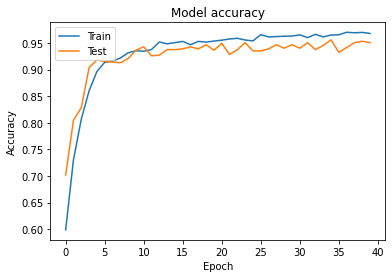

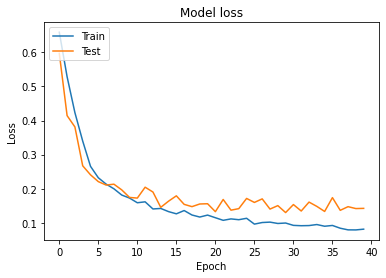

In [7]:
train_generator , val_generator, test_generator = collect_eye_generators()
history = train(train_generator,val_generator, model_type="eye")
plot_training_loss(history)

In [8]:
!ls
eye_model = load_model('eye')
print(eye_model.summary())
#predict_with_generator(train_generator, test_generator, model_type="eye")


dataset       model-eye.json  model-face.json  results-face.csv
model-eye.h5  model-face.h5   results-eye.csv  robust_sleep_net.ipynb
[INFO] loading eye model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 11, 11, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                

# Facial Image Model

[INFO] loading images...
[INFO] Training data info:
Found 1559 images belonging to 2 classes.
[INFO] Validation data info:
Found 389 images belonging to 2 classes.
[INFO] Testing data info:
Found 485 images belonging to 2 classes.
[INFO] Training face model
[INFO] Initialize Neural Network
[INFO] Training network for 40 epochs...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
48/48 [==============================] - 646s 13s/step - loss: 0.6929 - accuracy: 0.5301 - precision: 0.3856 - recall: 0.4577 - f1_score: 0.3586 - val_loss: 0.6868 - val_accuracy: 0.5729 - val_precision: 0.5558 - val_recall: 0.8488 - val_f1_score: 0.6661
Epoch 2/40
48/48 [==============================] - 11s 223ms/step - loss: 0.6818 - accuracy: 0.5503 - precision: 0.5749 - recall: 0.5223 - f1_score: 0.4852 - val_loss: 0.6376 - val_accuracy: 0.6146 - val_precision: 0.6680 - val_recall: 0.4614 - val_f1_score: 0.5360
Epoch 3/40
48/48 [==============================] - 11s 225ms/step - loss: 0.6442 - accuracy: 0.6144 - precision: 0.6248 - recall: 0.6948 - f1_score: 0.6393 - val_loss: 0.6341 - val_accuracy: 0.6432 - val_precision: 0.6955 - val_recall: 0.5384 - val_f1_score: 0.6016
Epoch 4/40
48/48 [==============================] - 11s 226ms/step - loss: 0.6413 - accuracy: 0.6309 - precision: 0.6437 - recall: 0.7253 - f1_score: 0.6687 - val_loss: 0.5917 - val_accuracy: 0.6719 -

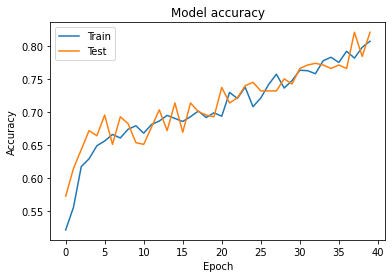

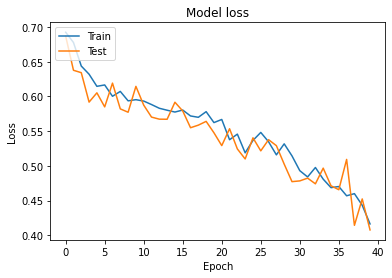

In [9]:
train_generator , val_generator, test_generator = collect_face_generators()
history = train(train_generator,val_generator, model_type="face")
plot_training_loss(history)

In [10]:
!ls
face_model = load_model('face')
print(face_model.summary())
predict_with_generator(train_generator, test_generator, model_type="face")

dataset       model-eye.json  model-face.json  results-face.csv
model-eye.h5  model-face.h5   results-eye.csv  robust_sleep_net.ipynb
[INFO] loading face model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 49, 49, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 23, 23, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8464)              0         
_________________________________________________________________
dense_3 (Dense)           

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


485/485 [==============================] - 170s 350ms/step
[INFO] Results:                                   Filename Predictions
0    closed/closed_eye_0001.jpg_face_1.jpg      closed
1    closed/closed_eye_0002.jpg_face_2.jpg      closed
2    closed/closed_eye_0003.jpg_face_2.jpg      closed
3    closed/closed_eye_0007.jpg_face_1.jpg      closed
4    closed/closed_eye_0009.jpg_face_1.jpg      closed
..                                     ...         ...
480               open/Dan_Dickau_0001.jpg        open
481             open/Dan_Guerrero_0001.jpg        open
482             open/Dan_Prinster_0001.jpg        open
483               open/Dan_Quayle_0001.jpg        open
484               open/Dan_Reeves_0001.jpg        open

[485 rows x 2 columns]
[INFO] Predictions are completed. Results are written to csv.
[INFO] Classification Report for model: face
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       239
           1       0.86  

In [11]:
evaluate(val_generator, model_type="face")

[INFO] loading face model
[INFO] Evaluating network...
Test loss: 0.4982146918773651
Test accuracy: 71.875
Test precision: 66.66666865348816
Test recall: 87.5
Test f1_score: 75.67567825317383
              precision    recall  f1-score   support

      closed       0.82      0.56      0.67        16
        open       0.67      0.88      0.76        16

    accuracy                           0.72        32
   macro avg       0.74      0.72      0.71        32
weighted avg       0.74      0.72      0.71        32



# Adversarially Train Face model

In [181]:
import keras
def generate_adversarial_attacks(train_generator, val_generator):
    tf.compat.v1.disable_eager_execution()
    model = load_model("face")

    # Create classifier wrapper
    print("[INFO] The Keras Classifier has {} classes".format(classifier.nb_classes))

    X_train, y_train = extract_x_y_data_from_generator(train_generator, max_iter=1000)
    X_test, y_test = extract_x_y_data_from_generator(val_generator, max_iter=450)

    from art.attacks.evasion import ProjectedGradientDescent
    adv_crafter = ProjectedGradientDescent(classifier, eps=8, eps_step=7, max_iter=20, targeted=False, 
                                    num_random_init=True)

    X_train_adv = adv_crafter.generate(X_train)
    X_test_adv = adv_crafter.generate(X_test)


    y_test = keras.utils.to_categorical(y_test, 2)

    # Evaluate the classifier on the adversarial samples
    preds = np.argmax(classifier.predict(X_test_adv), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("[INFO] Accuracy on adversarial samples: {:.2f}".format(acc * 100))
    return X_train_adv, y_train, X_test_adv, y_test

# Adversarially train the classifier on the adversarial samples
def adversarial_train(X_train_adv, y_train, model_type='face'):
    print("[INFO] Adversarial training started...")
    model = load_model(model_type)
    import tensorflow as tf

    tf.compat.v1.disable_eager_execution()
    classifier = KerasClassifier(model=model, clip_values=(0, 1))
    
    print("len(X_train_adv)",len(X_train_adv))
    print("len(y_train)",len(y_train))
    # https://stackoverflow.com/questions/56912176/target-array-shape-different-to-expected-output-using-tensorflow
    model.fit(X_train_adv, y_train, epochs=20)
    print("[INFO] Adversarial training finished")
    return model

def extract_x_y_data_from_generator(gen, max_iter=1000):
    #  max_iter: maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
    data = []     # store all the generated data batches
    labels = []   # store all the generated label batches
    i = 0
    for d, l in test_generator:
        data.append(d[0])
        labels.append(l[0])
        i += 1
        if i == max_iter:
            break

    X_test = data
    y_test = labels 
    print("Data size: {}".format(len(X_test)))
    return np.array(X_test),np.array(y_test)

def evaluate_adversarially_trained_model(model, X_test, y_test, verbose=0):
    score = model.evaluate(X_test, y_test, verbose = 0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1] * 100)
    print('Test precision:', score[2] * 100)
    print('Test recall:', score[3] * 100)
    print('Test f1_score:', score[4] * 100)


    predictions = model.predict(X_test) # predictions will be float numbers between
                                        # 0 and 1.
    predictions = (predictions > 0.5)    
    print(classification_report(y_test,
    predictions, target_names=['closed','open']))


In [182]:
# Generate adversarial attacks
X_train_adv, y_train, X_test_adv, y_test = generate_adversarial_attacks(train_generator,val_generator)


[INFO] loading face model
[INFO] The Keras Classifier has 1 classes
Data size: 1000
Data size: 450



[INFO] Accuracy on adversarial samples: 51.78


In [183]:
# Use the attacks to adversarially train the model
adversarially_trained_model = adversarial_train(X_train_adv, y_train, model_type='face')


[INFO] Adversarial training started...
[INFO] loading face model
len(X_train_adv) 1000
len(y_train) 1000
Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 13.8636 - accuracy: 0.4950 - precision: 0.1852 - recall: 0.2867 - f1_score: 0.2104
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.8957 - accuracy: 0.5070 - precision: 0.5443 - recall: 0.5727 - f1_score: 0.5093
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.7694 - accuracy: 0.5270 - precision: 0.5410 - recall: 0.5213 - f1_score: 0.5193
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.7550 - accuracy: 0.5260 - precision: 0.5581 - recall: 0.5843 - f1_score: 0.5534
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.7277 - accuracy: 0.5400 - precision: 0.5715 - recall: 0.5463 - f1_score: 0.5435
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/sample - 

In [185]:
# Evaluate adversarially trained model
evaluate_adversarially_trained_model(adversarially_trained_model, X_test, y_test, verbose=0)

ValueError: ignored

# Turn on Webcam to capture an image and test the models on the captured images
The code below turns on the webcam in Google Colab. Captures an image and the image can be tested against the model.

In [144]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
# https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename, binary

# from IPython.display import Image
import io
from PIL import Image
model_type = 'face' # 'eye'

def capture_and_display_image():
    try:
        filename, binary = take_photo()
        print('[INFO] Saved to {}'.format(filename))
        img = Image.open(io.BytesIO(binary))
        # Show the image which was just taken.
        display(img)
        return img
    except Exception as err:
        # Errors will be thrown if the user does not have a webcam or if they do not
        # grant the page permission to access it.
        print(str(err))
    

from PIL import Image
from numpy import asarray
from keras.preprocessing.image import img_to_array

def prepare_image(image, target):
    # if the image mode is not RGB, convert it
    if image.mode != "L":
        image = image.convert("L")

    # resize the input image and preprocess it
    image = image.resize(target)
    
    image = img_to_array(image)
    image /= 255
    image = np.expand_dims(image, axis=0)

    # return the processed image
    return image


# preprocess the image and prepare it for classification
def classify_from_webcam(model_type):
    assert model_type in ["eye", "face"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    img = capture_and_display_image()
    loaded_model = load_model(model_type)
    IMG_SIZE = determine_img_size_from_model_type(model_type)
    image = prepare_image(img, target=(IMG_SIZE,IMG_SIZE))
    prediction = loaded_model.predict(image)
    print("[INFO] Probability of eye being open:", prediction)
    if prediction < 0.5:
        predicted_label = 'closed'
    elif prediction >= 0.5:
        predicted_label = 'open'
    print("[INFO] Predicted label: {}".format(predicted_label))

<IPython.core.display.Javascript object>

[INFO] Saved to photo.jpg


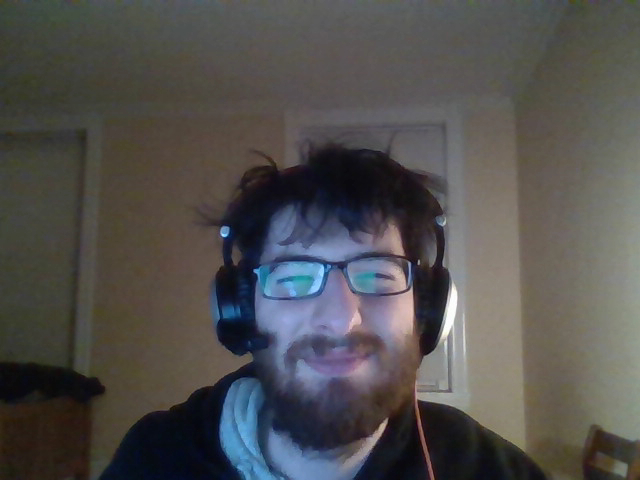

[INFO] loading eye model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[INFO] Probability of eye being open: [[0.97936034]]
[INFO] Predicted label: open


<IPython.core.display.Javascript object>

[INFO] Saved to photo.jpg


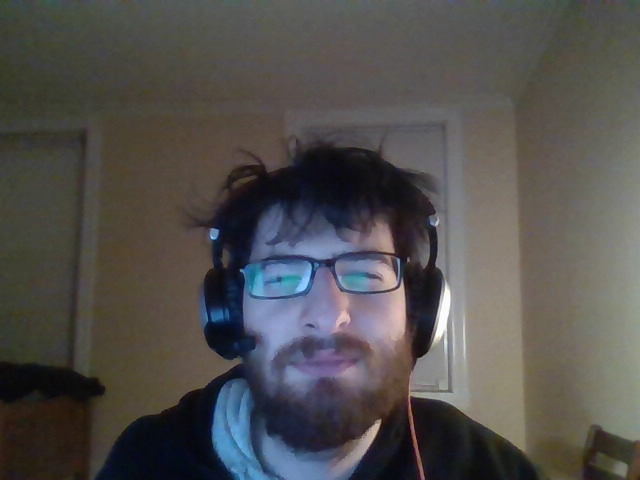

[INFO] loading face model
[INFO] Probability of eye being open: [[0.4978638]]
[INFO] Predicted label: closed


In [146]:
classify_from_webcam("eye")
classify_from_webcam("face")

# Turn on Webcam to capture  the video stream and test the models on the video stream
The code below turns on the webcam in Google Colab. Captures the video stream and tests it against the model. Note: There are some bugs in the code below, so video feature doesn't work for now.

In [20]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
# https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
# JS imports in Python's Google Collab is making the function name as undefined. 
# To truly test this, one might need to 
# adapt this code to be tensorflowjs compatible and test it outside of this function.
def capture_video_stream(filename='photo.jpg', quality=1):
  js = Javascript('''
//    import * as tf from '@tensorflow/tfjs';
//       import * as tfd from '@tensorflow/tfjs-data';
   async function takePhoto(quality) {
     
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.id = 'webcam'
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    // import * as tf from '@tensorflow/tfjs';
    // import * as tfd from '@tensorflow/tfjs-data';
    // // A webcam iterator that generates Tensors from the images from the webcam.
    // let webcam;
    // async function loadCustomModel() {
    // const sleepnet = await tf.loadLayersModel(
    //   'model-face.json'
    //   );

    //  return sleepnet
    // }
    // let isPredicting = false;
    // async function init() {
    //     const div = document.createElement('div');
    //     const predictButton = document.createElement('button');
    //     predictButton.textContent = 'Predict';
    //     div.appendChild(predictButton);

    //     const video = document.createElement('video');
    //     video.id = 'webcam'
    //     video.style.display = 'block';
    //     video.videoWidth = 224
    //     video.videoHeight = 224
    //     try {
    //         webcam = await tfd.webcam(document.getElementById('webcam'));
    //     } catch (e) {
    //         console.log(e);
    //         document.getElementById('no-webcam').style.display = 'block';
    //     }
    //         truncatedCustomModel = await loadCustomModel();
    //         truncatedCustomModel.predict(webcam)

    //     // Warm up the model. This uploads weights to the GPU and compiles the WebGL
    //     // programs so the first time we collect data from the webcam it will be
    //     // quick.
    //     const screenShot = await webcam.capture();
    //     truncatedCustomModel.predict(screenShot.expandDims(0));
    //     screenShot.dispose();
    // }

    // /**
    //  * Captures a frame from the webcam and normalizes it between -1 and 1.
    //  * Returns a batched image (1-element batch) of shape [1, w, h, c].
    //  */
    // async function getImage() {
    // const img = await webcam.capture();
    // const processedImg =
    //     tf.tidy(() => img.expandDims(0).toFloat().div(127).sub(1));
    // img.dispose();
    // return processedImg;
    // }


    // async function takePhoto(quality) {
    //   const div = document.createElement('div');
    //   const predictButton = document.createElement('button');
    //   predictButton.textContent = 'Predict';
    //   div.appendChild(predictButton);

    
    //   // Resize the output to fit the video element.
    //   google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

    //   // Wait for Capture to be clicked.
    //   await new Promise((resolve) => capture.onclick = resolve);

    //   const canvas = document.createElement('canvas');
    //   canvas.width = video.videoWidth;
    //   canvas.height = video.videoHeight;
    //   canvas.getContext('2d').drawImage(video, 0, 0);
    //   stream.getVideoTracks()[0].stop();
    //   div.remove();
    //   return canvas.toDataURL('image/jpeg', quality);
    // }

    // document.getElementById('predict').addEventListener('click', () => {
    //     isPredicting = true;
    //     predict();
    // });
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename, binary

<IPython.core.display.Javascript object>

[INFO] loading face model
Saved to photo.jpg


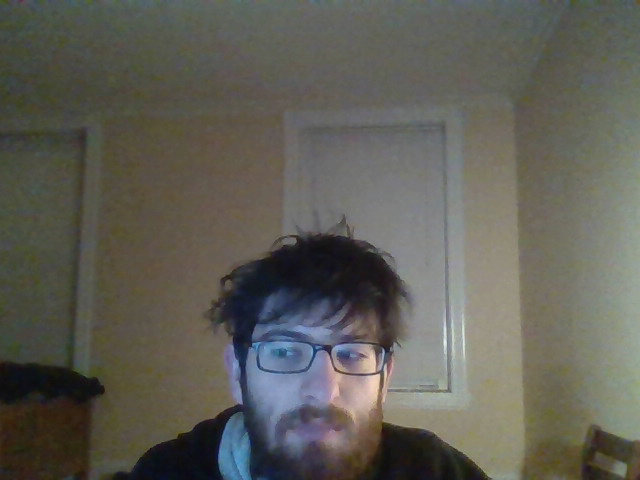

In [21]:
# from IPython.display import Image
import io
from PIL import Image
model_type = 'face' # 'eye'
try:
  filename, binary = capture_video_stream()
  if model_type == 'face':
      IMG_SIZE = 100
      loaded_model = load_model('face')
  elif model_type == 'eye':
      IMG_SIZE= 24
      loaded_model = load_model('eye')

  print('Saved to {}'.format(filename))
  img = Image.open(io.BytesIO(binary))
  # Show the image which was just taken.
  display(img)
  # Predict the eyes closed or not
#   predicted = predict(img, loaded_model)
#   print(predicted)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Face Recognition

In [22]:
import os
import cv2
import face_recognition
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from imutils.video import VideoStream
from imutils.video import FPS
from imutils.video import WebcamVideoStream


def init():
    face_cascPath = 'haarcascade_frontalface_alt.xml'
    # face_cascPath = 'lbpcascade_frontalface.xml'

    open_eye_cascPath = 'haarcascade_eye_tree_eyeglasses.xml'
    left_eye_cascPath = 'haarcascade_lefteye_2splits.xml'
    right_eye_cascPath ='haarcascade_righteye_2splits.xml'
    dataset = 'faces'

    face_detector = cv2.CascadeClassifier(face_cascPath)
    open_eyes_detector = cv2.CascadeClassifier(open_eye_cascPath)
    left_eye_detector = cv2.CascadeClassifier(left_eye_cascPath)
    right_eye_detector = cv2.CascadeClassifier(right_eye_cascPath)

    print("[LOG] Opening webcam ...")
    video_capture = cv2.VideoCapture(0)
    # fps = FPS().start()
    # video_capture = VideoStream(src=0).start()

    # global capture
    # global Classifier
    # global FacenetHelpers
    # Classifier = Classifier()
    # FacenetHelpers = FacenetHelpers()
    # try:
    #     video_capture = WebcamVideoStream(src=0).start()
    #     print("-- CONNECTED TO WEBCAM")
    # except Exception as e:
    #     print("-- FAILED TO CONNECT TO WEBCAM")
    #     print(str(e))
  

    model = load_model('eye')


    print("[LOG] Collecting images ...")
    images = []
    for direc, _, files in tqdm(os.walk(dataset)):
        for file in files:
            if file.endswith("jpg"):
                images.append(os.path.join(direc,file))
    return (model,face_detector, open_eyes_detector, left_eye_detector,right_eye_detector, video_capture, images) 

def process_and_encode(images):
    # initialize the list of known encodings and known names
    known_encodings = []
    known_names = []
    print("[LOG] Encoding faces ...")

    for image_path in tqdm(images):
        # Load image
        image = cv2.imread(image_path)
        # Convert it from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
     
        # detect face in the image and get its location (square boxes coordinates)
        boxes = face_recognition.face_locations(image, model='hog')

        # Encode the face into a 128-d embeddings vector
        encoding = face_recognition.face_encodings(image, boxes)

        # the person's name is the name of the folder where the image comes from
        name = image_path.split(os.path.sep)[-2]

        if len(encoding) > 0 : 
            known_encodings.append(encoding[0])
            known_names.append(name)

    return {"encodings": known_encodings, "names": known_names}

def isBlinking(history, maxFrames):
    """ @history: A string containing the history of eyes status 
         where a '1' means that the eyes were closed and '0' open.
        @maxFrames: The maximal number of successive frames where an eye is closed """
    for i in range(maxFrames):
        pattern = '1' + '0'*(i+1) + '1'
        if pattern in history:
            return True
    return False

def detect_and_display(model, video_capture, face_detector, open_eyes_detector, left_eye_detector, right_eye_detector, data, eyes_detected):
        frame = video_capture.read()
        print("FRAME",frame)
        # resize the frame
        frame = cv2.resize(frame, (0, 0), fx=0.6, fy=0.6)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detect faces
        faces = face_detector.detectMultiScale(
            gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(50, 50),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        # for each detected face
        for (x,y,w,h) in faces:
            # Encode the face into a 128-d embeddings vector
            encoding = face_recognition.face_encodings(rgb, [(y, x+w, y+h, x)])[0]

            # Compare the vector with all known faces encodings
            matches = face_recognition.compare_faces(data["encodings"], encoding)

            # For now we don't know the person name
            name = "Unknown"

            # If there is at least one match:
            if True in matches:
                matchedIdxs = [i for (i, b) in enumerate(matches) if b]
                counts = {}
                for i in matchedIdxs:
                    name = data["names"][i]
                    counts[name] = counts.get(name, 0) + 1

                # determine the recognized face with the largest number of votes
                name = max(counts, key=counts.get)

            face = frame[y:y+h,x:x+w]
            gray_face = gray[y:y+h,x:x+w]

            eyes = []
            
            # Eyes detection
            # check first if eyes are open (with glasses taking into account)
            open_eyes_glasses = open_eyes_detector.detectMultiScale(
                gray_face,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30),
                flags = cv2.CASCADE_SCALE_IMAGE
            )
            # if open_eyes_glasses detect eyes then they are open 
            if len(open_eyes_glasses) == 2:
                eyes_detected[name]+='1'
                for (ex,ey,ew,eh) in open_eyes_glasses:
                    cv2.rectangle(face,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            
            # otherwise try detecting eyes using left and right_eye_detector
            # which can detect open and closed eyes                
            else:
                # separate the face into left and right sides
                left_face = frame[y:y+h, x+int(w/2):x+w]
                left_face_gray = gray[y:y+h, x+int(w/2):x+w]

                right_face = frame[y:y+h, x:x+int(w/2)]
                right_face_gray = gray[y:y+h, x:x+int(w/2)]

                # Detect the left eye
                left_eye = left_eye_detector.detectMultiScale(
                    left_face_gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(30, 30),
                    flags = cv2.CASCADE_SCALE_IMAGE
                )

                # Detect the right eye
                right_eye = right_eye_detector.detectMultiScale(
                    right_face_gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(30, 30),
                    flags = cv2.CASCADE_SCALE_IMAGE
                )

                eye_status = '1' # we suppose the eyes are open

                # For each eye check wether the eye is closed.
                # If one is closed we conclude the eyes are closed
                for (ex,ey,ew,eh) in right_eye:
                    color = (0,255,0)
                    pred = predict(right_face[ey:ey+eh,ex:ex+ew],model)
                    if pred == 'closed':
                        eye_status='0'
                        color = (0,0,255)
                    cv2.rectangle(right_face,(ex,ey),(ex+ew,ey+eh),color,2)
                for (ex,ey,ew,eh) in left_eye:
                    color = (0,255,0)
                    pred = predict(left_face[ey:ey+eh,ex:ex+ew],model)
                    if pred == 'closed':
                        eye_status='0'
                        color = (0,0,255)
                    cv2.rectangle(left_face,(ex,ey),(ex+ew,ey+eh),color,2)
                eyes_detected[name] += eye_status

            # Each time, we check if the person has blinked
            # If yes, we display its name
            if isBlinking(eyes_detected[name],3):
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                # Display name
                y = y - 15 if y - 15 > 15 else y + 15
                cv2.putText(frame, name, (x, y), cv2.FONT_HERSHEY_SIMPLEX,0.75, (0, 255, 0), 2)

        return frame



(model, face_detector, open_eyes_detector,left_eye_detector,right_eye_detector, video_capture, images) = init()
data = process_and_encode(images)

eyes_detected = defaultdict(str)
while True:
    frame = detect_and_display(model, video_capture, face_detector, open_eyes_detector,left_eye_detector,right_eye_detector, data, eyes_detected)
    cv2.imshow("Face Liveness Detector", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
video_capture.stop()

RuntimeError: ignored